<a href="https://colab.research.google.com/github/georginagorlero/Metodos-Cuantitativos-2/blob/main/Trabajo_final_2021_Mesel_Gorlero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Metodos Cuantitativos Aplicados a Estudios Urbanos** \\
Profesor Ricardo Pasquini \\
Universidad Torcuato Di Tella \\
rpasquini@gmail.com

**Alumnos:** Gorlero, Georgina - Mesel, Felipe


En este trabajo final vamos a analizar si el gradiente de alquileres asociado a la teoría de la aglomeracion ha cambiado a raíz del COVID en el Área Metropolitana de Buenos Aires (AMBA), utilizando para ello datos de Properati. 


# Preparacion del ambiente de trabajo y del geodataframe

En primer término instalamos los paquetes geopandas, pandas, statsmodels, numpy, contextily y matplotlib:

In [ ]:
!pip install geopandas

In [ ]:
import geopandas as gpd
import pandas as pd
import statsmodels.api as sm
import numpy as np
!pip install contextily
import contextily as cx
import matplotlib.pyplot as plt

En la siguiente celda de código, incorporamos la url correspondiente al AMBA, que es el área con la que vamos a trabajar y luego graficamos los anuncios de la base de datos -a partir de los cuales puede verse graficado un mapa del AMBA-.

In [ ]:
gdf=gpd.GeoDataFrame.from_file("https://github.com/rpasquini/urban_gradient_and_covid/blob/main/data/amba40.zip?raw=true")

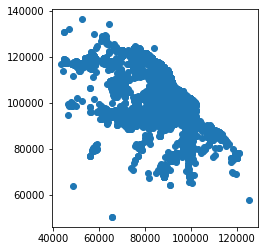

In [ ]:
gdf.plot()

Vamos a eliminar el 5% de las propiedades de mayor precio de manera de evitar problemas de outliers. 

In [ ]:
gdf=gdf.loc[gdf.price<gdf.price.quantile(.95)]

Las variables disponibles en el dataframe son las siguientes:

In [ ]:
gdf.columns

Index(['type', 'type_i18n', 'country', 'developmen', 'operation', 'operation_',
       'rooms', 'bedrooms', 'bathrooms', 'surface_to', 'surface_co', 'price',
       'currency', 'price_peri', 'title', 'lat', 'lon', 'l1', 'l2', 'l3', 'l4',
       'l5', 'l6', 'distanciaC', 'start_mont', 'start_year', 'infla',
       'adjprice', 'geometry'],
      dtype='object')

Nos interesan las siguientes:
- 'bedrooms': Numero de habitaciones
- 'surface_to': Superficie total
- 'price': Valor de alquiler en la moneda local
- 'start_mont' Mes en que se empezo a ofrecer el anuncio. Ojo que dice mont y no month.
- 'start_year': Año en el que se comenzó a ofrecer
- 'adjprice': Precio ajustado por inflacion
- 'distanciaC': Distancia al centro de negocios o *central business district* CBD.


# Preguntas  

##Pregunta 1
Estimaremos un modelo para identificar la presencia de un gradiente urbano. Nuestra intención es verificar si existe una relación entre la distancia al centro de negocios de la ciudad y el valor de los alquileres.  

Propondremos inicialmente la estimación del siguiente modelo
$$
alquiler_i=\beta_0+\beta_1distanciaC_i+\epsilon_i
$$
Donde alquiler_i es el valor del alquiler del inmueble $i$, y $dist_i$ representa la distancia respecto al centro de negocios de la ciudad en cuestión. La distancia está computada en metros. La moneda del alquiler depende de la ciudad en cuestión (ver detalles en planilla de referencias)


**Importante:** Los que trabajen con datos de Argentina deben utilizar la variable *adjprice* en vez de *price*


1.a Estime el modelo. Interprete los coeficientes estimados. \\
1.b. Diagnostique si la variable $distancia$ tiene un efecto estadísticamente significativo en el alquiler. \\
1.c Evalue la bondad de ajuste del modelo sobre la variabilidad del alquiler \\
1.d ¿Que dicen los resultados sobre la hipotesis de efectos de la aglomeracion en el valor del alquiler?

##**Respuestas** a la Pregunta 1

**1.a Estimamos el modelo e interpretamos los coeficientes estimados.**

Para poder estimar nuesto modelo
$$
alquiler_i=\beta_0+\beta_1distanciaC_i+\epsilon_i
$$
vamos a precisar realizar, primero, tres pasos. 

1- Asegurarnos de que no haya datos vacíos (missing) en ninguna de las variables que vamos a utilizar. Estas variables son: *distanciaC* y *adjprice*. Para realizarlo vamos a utilizar el método dropna().


In [ ]:
datos=gdf[['adjprice', 'distanciaC']]

In [ ]:
datos=datos.dropna()

In [ ]:
datos

,adjprice,distanciaC
0,13404.255319,3782.819022
1,15000.000000,1584.291795
3,15000.000000,768.329029
4,17142.857143,2087.630655
5,6600.000000,14714.206673
...,...,...
29905,14000.000000,4138.611068
29906,17432.432432,5564.613456
29907,10125.000000,28550.497724
29908,19411.764706,28671.344310


2- En este paso, vamos a separar la variable a explicar (dependiente) de la explicativa (independiente)

In [ ]:
Y=datos.adjprice
X=datos.distanciaC

3- Como en nuestro caso el modelo tiene una constante vamos a agregar a la variable explicativa una columna de unos. Para esto utilizamos el método add_constant() de sm.

In [ ]:
X=sm.add_constant(X)
X

,const,distanciaC
0,1.0,3782.819022
1,1.0,1584.291795
3,1.0,768.329029
4,1.0,2087.630655
5,1.0,14714.206673
...,...,...
29905,1.0,4138.611068
29906,1.0,5564.613456
29907,1.0,28550.497724
29908,1.0,28671.344310


Ahora ya contamos con todo lo necesario para poder estimar nuesto modelo. Por lo tanto, vamos a comenzar por asignarle a una variable el nombre del modelo. El modelo lo generamos través del método OLS (regresión de mínimos cuadrados ordinarios), especificando cuáles son sus variables (explicativas y a explicar).

In [ ]:
modelo=sm.OLS(Y,X)

Luego creamos la variable resultados y corremos el método fit() para ajustar nuestro modelo

In [ ]:
resultados=modelo.fit()

Ahora estamos en condiciones de imprimir nuestros resultados.

In [ ]:
print(resultados.summary())

                            OLS Regression Results                            
Dep. Variable:               adjprice   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     522.3
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          1.49e-114
Time:                        20:59:59   Log-Likelihood:            -2.9601e+05
No. Observations:               28345   AIC:                         5.920e+05
Df Residuals:                   28343   BIC:                         5.920e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.806e+04     71.769    251.614      0.0

Por lo tanto, nuestro resultado es: 

$$
alquiler_i=18.060-0,10 * distanciaC_i+\epsilon_i
$$


Como podemos ver, β0 -la constante de nuestra recta- es 18.060 que representa el valor promedio del alquiler cuando la distancia al centro de negocios es 0. Por otro lado, el coeficiente que acompaña la distancia ($\beta_1$) es negativo (-0,10) porque hay una relación inversa entre el precio de los alquileres y la distancia al CBD, es decir, que a medida que nos alejamos del centro de negocios, el precio tiende a disminuir. Este coeficiente (β1) representa la pendiente de la recta. 

**1.b. Diagnosticamos si la variable  distancia  tiene un efecto estadísticamente significativo en el alquiler.**

Podemos afirmar que la variable distancia tiene un efecto estadísticamente significativo en el alquiler en tanto el p-valor es igual a cero, lo que significa que se rechaza la hipotesis nula β1=0. En otras palabras, podemos afirmar que β1 tiene un efecto en el alquiler, es decir, es distinto de 0. 
Por otro lado, esto también lo podemos observar al ver el valor de t que en este caso es menor a -2, es decir, está en zona de rechazo.

**1.c Evaluamos la bondad de ajuste del modelo sobre la variabilidad del alquiler.**

Para evaluar la bondad de ajuste del modelo vamos a revisar el valor de R². R² es un valor que se calcula como la razón entre la variabilidad explicada por el modelo sobre la variabilidad total de nuestros datos y es siempre un número entre el 0 y 1. Siendo 1 cuando explica la totalidad de la variabilidad y 0 cuando no la explica en lo absoluto. En este caso ese valor es de 0,018, un valor muy bajo. Nuestro modelo solo explica un 1,8% de la variabilidad de los datos. 

Que R² dé un valor bajo, de todas maneras, no significa que nuestro modelo de regresión lineal no sea adecuado, los coeficientes que calculamos son estadísticamente significativos y muestran una relación entre la variable explicativa y la explicada. Simplemente nos da la pauta de que hay otro tipo de relaciones que no estamos captando. En los siguientes puntos vamos a complejizar el modelo incorporando otras variables que pueden ayudarnos a tener una mayor bondad de ajuste. 

Otro valor que nos da la pauta de la bondad de ajuste es el error cuadrático medio. Para poder calcularlo necesitamos calcular primero todas las $\hat{Y}$, para luego tener los residuos $ \hat{\epsilon_i}= Y_i - \hat{Y_i} $.

In [ ]:
ypred = resultados.predict(X)

In [ ]:
residuos=Y-ypred
residuos

0       -4273.571321
1       -2898.741649
3       -2980.732183
4        -705.307416
5       -9979.406040
            ...     
29905   -3642.075524
29906     -66.353836
29907   -5064.091507
29908    4234.816248
29909   -2500.387726
Length: 28345, dtype: float64

In [ ]:
MSE = resultados.mse_resid**0.5
MSE

8302.887861131905

Este valor lo que nos dice es que el error promedio es de $8302, teniendo en cuenta que β0 = 18060, podemos decir que el error promedio es muy alto y que nuestro modelo no toma gran parte de la variabilidad de los datos. En otras palabras existe una diferencia promedio muy alta entre los datos y nuestra recta de predicción. 

**1.d ¿Que dicen los resultados sobre la hipotesis de efectos de la aglomeracion en el valor del alquiler?**


A partir de una primera revisión de la base de datos con la que trabajamos, podíamos ver que hay una mayor cantidad de anuncios y mayores precios concentrados en el centro de negocios y, a medida que nos alejamos, los anuncios y los precios tienden a descender. Esto lo podemos ver mapeado de la siguiente manera:

(-59.2, -58.0, -35.0, -34.1)

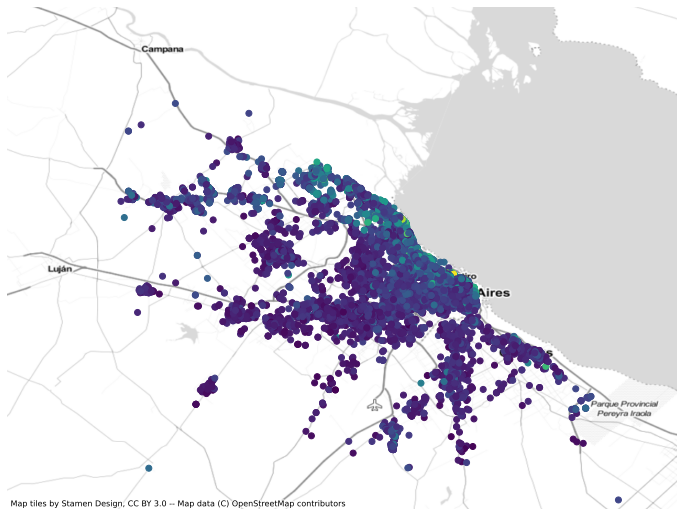

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf.to_crs("EPSG:4326").plot(ax=ax,column='adjprice')
ax.set_xlim(-59.2, -58)
ax.set_ylim(-35, -34.1)
cx.add_basemap(ax, crs=gdf.to_crs(epsg=4326).crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

Sin embargo, estos efectos positivos de la aglomeración no podían afirmarse hasta tanto no se realizara un test de hipótesis. En los primeros puntos de este trabajo, pudimos probar que existe una relación estadísticamente significativa entre la distancia al CBD y los precios de los alquileres. Al haber rechazado la hipótesis nula, podemos estar seguros de que efectivamente el valor de los alquileres es mayor en las cercanías del CBD, lo que da cuenta de un efecto positivo de aglomeración. 

##Pregunta 2
En base a los resultados del modelo anterior: \\
a. Realice una predicción para el valor de un alquiler a 100 metros del CBD \\
b. Realice una predicción para el valor de un alquiler a 5km del CBD. \\
c. Realice un grafico cross-plot con las distancias al CBD en el eje horizontal y los precios en el eje vertical. Superponga la predicción del modelo. Ayuda: puede consultar este [notebook](https://github.com/rpasquini/metodos_cuantitativos_2021/blob/main/1_Introduccion.ipynb)

##**Respuestas** a la Pregunta 2

a. Con nuestro modelo ya armado ahora podemos predecir valores para un alquiler a cierta distancia del CBD. Comenzaremos por predecir el valor que tomará un alquiler a 100 metros del CBD. Para realizarlo, utilizaremos nuestra recta de predicción 
$$\hat{Y}= \hat{\beta_0} + \hat{\beta_1} * X $$


In [ ]:
resultados.params

const         18057.936328
distanciaC       -0.100483
dtype: float64

In [ ]:
resultados.params['const']+resultados.params['distanciaC']*100

18047.888009528593

Como era de esperarse, el valor que toma un alquiler a 100 metros del CBD es muy similar al valor de β0, dado que no estamos a una distancia considerable. 

b. Podemos también realizar una predicción para el valor de un alquiler a 5km (5000 metros).

In [ ]:
resultados.params['const']+resultados.params['distanciaC']*5000

17555.520424315295

A diferencia del punto anterior, a 5km de distancia del CBD empezamos a notar una diferencia en el valor del precio de los alquileres. Este descenso, sin embargo, es de apenas aproximadamente un 2,8% respecto del valor promedio en el CBD. Esto nos da la pauta de que para encontrar grandes diferencias de precio, tendremos que encontrarnos a varios kilómetros de distancia. 

**c.** Podríamos realizar una predicción del valor del alquiler para cada una de las distancias al Centro de Negocios que querramos conocer. Podemos, por ejemplo, ver todos los valores que toma $\hat{Y}$ en cada uno de los valor de X que tienen nuestros datos y tener una primera vista de cómo se verá nuestra recta. Para esto primero calculamos ypred (los valores predichos de y). 

In [ ]:
ypred = resultados.predict(X)

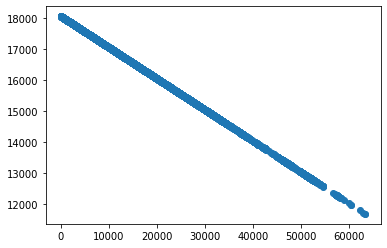

In [ ]:
plt.scatter(datos.distanciaC, ypred)

Una manera más sencilla de poder visualizar todos los valores que toma el alquiler por cada distanciaC es trazar la recta del modelo. Vamos a realizar un gráfico crossplot con todos los valores que toman los alquileres publicados en Properati y sus distancias, y a ellos vamos a superponerle la recta de la predicción.

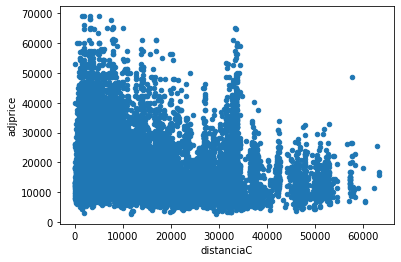

In [ ]:
datos.plot.scatter(x='distanciaC',  y='adjprice')

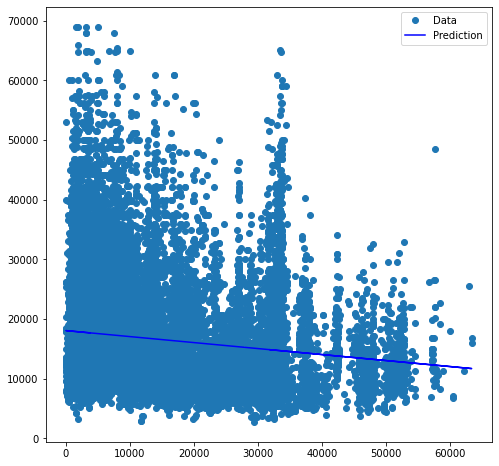

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(datos['distanciaC'], datos['adjprice'], 'o', label="Data")
ax.plot(datos['distanciaC'], ypred, 'b-', label="Prediction")
ax.legend(loc="best");

Viendo la superposición de la distribución de los datos y la recta de nuestro modelo, podemos observar que pareciera que el gradiente de precios es un poco más pronunciado que la pendiente de la recta de la predicción. Esto se debe en gran medida al conjunto de datos cerca de los 30000 metros que tienen valores más altos de alquiler. Volviendo a revisar el mapa del punto 1.d, podemos ver que posiblemente sean los valores de los anuncios de la Zona Norte del AMBA que son más elevados que otros valores a la misma distancia del CBD lo que aplana un poco nuestra recta. Esto se puede ver con mayor claridad en un mapa geolocalizado de los residuos.

In [ ]:
datos['residuos']=residuos

(-59.2, -58.0, -35.0, -34.1)

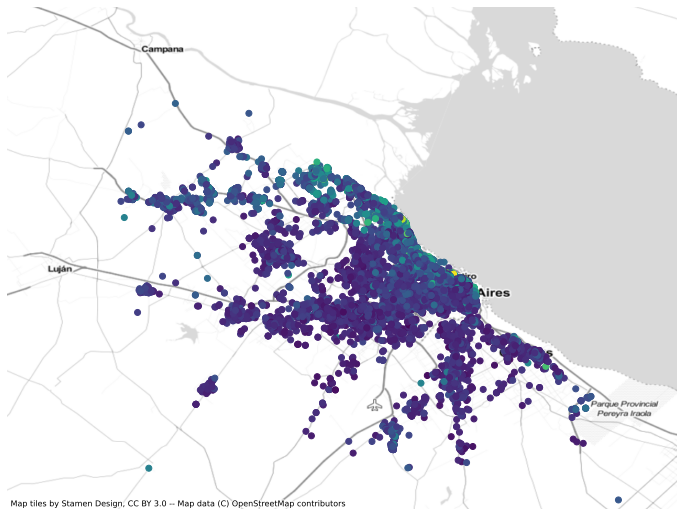

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf.join(datos['residuos']).to_crs("EPSG:4326").plot(ax=ax, column='residuos')
ax.set_xlim(-59.2, -58)
ax.set_ylim(-35, -34.1)
cx.add_basemap(ax, crs=gdf.to_crs(epsg=4326).crs.to_string(), source=cx.providers.Stamen.TonerLite)
ax.axis('off')

## Pregunta 3

Analice el cumplimiento del supuesto de errores normales. Utilice para ello alguno de los gráficos de diagnóstico sobre los mismos que  vimos en clase.
 Luego responda, explicando sus resultados: \\
a. ¿Presentan los residuos una distribución normal? \\
b. ¿Puede considerarse válido el test de hipótesis en este caso particular? Por qué si o por qué no? \\

##**Respuestas** a la Pregunta 3


Para poder inferir que lo que sucede en nuestra muestra de datos Properati es estadísticamente representativo de lo que sucede en la población en general tenemos que realizar nuestro test de hipótesis. Sin embargo, antes de poder considerarlo válido tenemos que revisar si la distribución del error es una distribución normal. 
Para esto, en primer lugar volvemos a calculamos los residuos. 
$$ \hat{\epsilon_i}= Y_i - \hat{Y_i} $$


In [ ]:
residuos=Y-ypred
residuos

0       -4273.571321
1       -2898.741649
3       -2980.732183
4        -705.307416
5       -9979.406040
            ...     
29905   -3642.075524
29906     -66.353836
29907   -5064.091507
29908    4234.816248
29909   -2500.387726
Length: 28345, dtype: float64

Ya calculados los residuos podemos realizar un histograma para ver su distribución. 

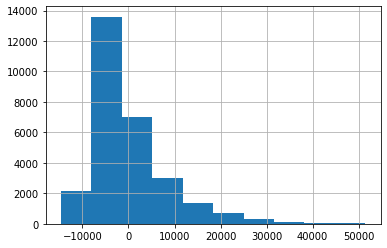

In [ ]:
residuos.hist()

**a.** Como podemos ver el histograma nos da una distribución asimétrica con una cola alargada hacia la derecha. Es decir, no hay una distribución normal de los residuos. Esto lo que nos indica es que hay algunos valores extremos positivos entre nuestros datos. Como mencionamos anteriormente podemos intuir que estos valores tienen que ver en parte con los alquileres elevados que encontramos en los alrededores de los 30000 metros y que, como mapeamos en el punto anterior, pudimos ver en la Zona Norte del AMBA. 

**b.** Si bien en el punto que sigue haremos una transformación logarítmica a los fines de obtener una distribución normal del error, no podemos dejar de considerar el gran tamaño de la muestra con la que estamos trabajando, lo que lleva a pensar en que no puede descartarse de plano la validez del test de hipótesis por más de que la distribución en este caso no sea estrictamente normal. 

## Pregunta 4

Reestime el modelo anterior haciendo alguna transformación en la forma funcional que ayude al cumplimiento de la normalidad de los errores. Provea una interpretación de los coeficientes obtenidos  luego de la transformación.

##**Respuestas** a la Pregunta 4

Primero, teniendo en cuenta que la distribución de los residuos está intimamente relacionada con la distribución de las variables X e Y ( distancia y precios), vamos a revisarlas para definir qué transformación es la adecuada para cumplir con la normalidad de los errores.

Vemos, en primer lugar, la distribución de los precios.

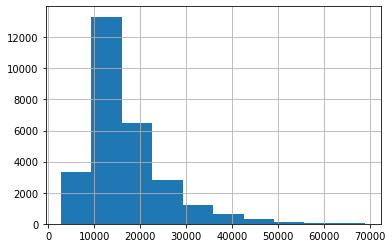

In [ ]:
datos.adjprice.hist()

Como podemos ver la distribución de los precios no es normal y es, como vimos en los residuos, asimétrica con cola a la derecha. 
Revisamos, en segundo lugar, la distribución de las distancias.

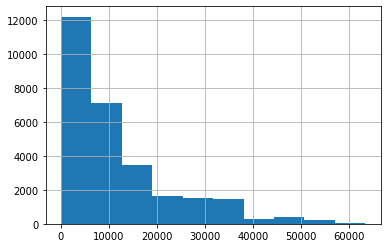

In [ ]:
datos.distanciaC.hist()

Vemos que la distribución tampoco es normal y es asimétrica también con cola a la derecha. En este caso, era de esperarse este tipo de distribución teniendo en cuenta que las distancias son siempre positivas y que la mayor cantidad de anuncios está concentrada en el la Ciudad de Buenos Aires, con pocos anuncios en distancias mayores.

Otro gráfico que nos puede ayudar a entender por qué no es normal la distribución de los residuos es un scatterplot de los residuos en las distanciaC. 

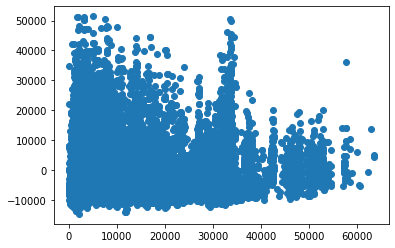

In [ ]:
plt.scatter(datos.distanciaC,residuos)

En este gráfico podemos observar que no sólo tenemos los mayores residuos en el área cercana al Centro de Negocios sino que hay un salto que ya habíamos encontrado en el gráfico de dispersión del punto 1 y que responde a un salto en los precios en las distancias cercanas a los 30 km.  

Teniendo en cuenta lo visto en los gráficos anteriores, tomamos la decisión de transformar la variable Y (precios) del modelo en el logaritmo de Y -log(Y)- de manera de "aplastar" los valores extremos que desajustan la normalidad de los residuos. Vale aclarar que teniendo en cuenta que las distancias tampoco tienen una distribución normal, podríamos también usar el logaritmo de X. Sin embargo, al contar con gran cantidad de datos, vamos a ver a continuación que sólo con transformar una de ellas ya vamos a poder asegurarnos la normalidad de los residuos.



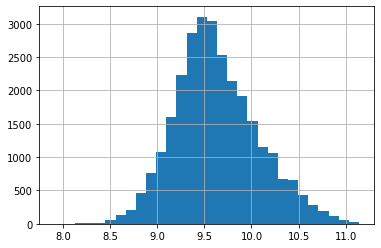

In [ ]:
logY=np.log(Y)
logY.hist(bins=30)

Como podemos observar, al tranformar nuestra variable por log(Y), esta ahora sí presenta una distribución normal. Ahora estimaremos nuestro modelo. 

Modelo propuesto

$log(adjprice_i)=\beta_0+\beta_1*distanciaC_i+\epsilon_i$

In [ ]:
modelologY=sm.OLS(logY,X)
resultadoslogY=modelologY.fit()
print(resultadoslogY.summary())

                            OLS Regression Results                            
Dep. Variable:               adjprice   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1024.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          8.50e-221
Time:                        21:00:18   Log-Likelihood:                -16520.
No. Observations:               28345   AIC:                         3.304e+04
Df Residuals:                   28343   BIC:                         3.306e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7180      0.004   2594.012      0.0

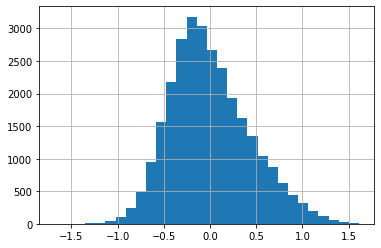

In [ ]:
residuoslogY=logY-resultadoslogY.predict(X)
residuoslogY.hist(bins=30)

Como podemos observar en el último gráfico los residuos ahora tienen una distribución normal, por lo tanto, vamos a estar seguros de que podemos considerar válidos los resultados de nuestro test de hipótesis. 

En este nuevo modelo, β0 es igual a 9,718 y β1 es -0,000007 que representa el cambio porcentual de Y (-0,0007%) cuando X varía en una unidad (1m) . Por otro lado, nuevamente el p-valor es 0, por lo tanto, rechazamos la hipotesis nula y podemos decir que hay una relación estadísticamente significativa entre las distancias y los precios de alquiler. También vemos que R² cambia ligeramente, con la variable Y como logaritmo, el modelo explica un porcentaje más alto de la variablididad de los datos (cambia de 1,8% a 3,5%).

## Pregunta 5

Siguiendo con el objetivo de identificar el efecto de la aglomeración usando la distancia al CBD, vamos a considerar ahora la incorporación del control de la superficie del departamento como una variable de control. \\
 a. En términos téoricos: ¿Es la superficie del departamento una  variable *relevante* que no puede ser omitida? ¿Por
   qué si o por qué no? \\
 b. Incorpore la superificie del departamento al modelo. Compute el modelo y explique todos los resultados. En particular, compare los resultados del coeficiente que acompaña a distancia antes y después de la incorporación del control.

## **Respuestas** a la Pregunta 5

**a.** En términos teóricos, la superficie del departmento es una variable relevante toda vez que es un factor explicativo del precio que además tiene un efecto sobre el precio del alquiler que es independiente del efecto que tiene sobre el mismo la variable que venimos considerando en el modelo (distancia). Podríamos intuir un relación entre distancia y superficie (mayor superficie de los inmuebles más lejanos al Centro de Negocios) pero al estar considerando solamente precios de alquiler de departamentos no creemos que estas diferencias sean tan significativas. Lo corroboraremos con la estimación del modelo.

**b.** Incorporamos la variable superficie total al modelo.

Modelo incorporando la variable superficie del departamento:

$log(adjprice_i)=\beta_0+\beta_1*distanciaC_i+ \beta_2*surface_i +\epsilon_i$

In [ ]:
datossup=gdf[['adjprice', 'distanciaC', 'surface_to']]
datossup=datossup.dropna()
datossup['logY']=np.log(datossup.adjprice)

datossup


,adjprice,distanciaC,surface_to,logY
0,13404.255319,3782.819022,36,9.503327
1,15000.000000,1584.291795,39,9.615805
3,15000.000000,768.329029,52,9.615805
4,17142.857143,2087.630655,51,9.749337
5,6600.000000,14714.206673,40,8.794825
...,...,...,...,...
29905,14000.000000,4138.611068,31,9.546813
29906,17432.432432,5564.613456,55,9.766088
29907,10125.000000,28550.497724,35,9.222763
29908,19411.764706,28671.344310,80,9.873635


In [ ]:
logY=datossup.logY
X=datossup[['distanciaC','surface_to']]
X=sm.add_constant(X)
X

,const,distanciaC,surface_to
0,1.0,3782.819022,36
1,1.0,1584.291795,39
3,1.0,768.329029,52
4,1.0,2087.630655,51
5,1.0,14714.206673,40
...,...,...,...
29905,1.0,4138.611068,31
29906,1.0,5564.613456,55
29907,1.0,28550.497724,35
29908,1.0,28671.344310,80


In [ ]:
modelo2=sm.OLS(logY,X)
resultadossup=modelo2.fit()
print(resultadossup.summary())

                            OLS Regression Results                            
Dep. Variable:                   logY   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     537.5
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          7.54e-230
Time:                        21:00:19   Log-Likelihood:                -16496.
No. Observations:               28345   AIC:                         3.300e+04
Df Residuals:                   28342   BIC:                         3.302e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7160      0.004   2588.141      0.0

En este nuevo modelo, β0 es igual a 9,716 y β1 es -0,00000736, valores casi idénticos a los que daba el modelo anterior. Esto nos confirma lo que mencionamos en el punto anterior de que distancia y superficies son independientes entre sí y, por lo tanto, la variable superficie es una variable relevante. β2 es 0,0000334 que es el porcentaje que cambia Y (0,00334%) cuando cambia una unidad de Z(superficie). 

Por otro lado, nuevamente el p-valor de β2 es 0, por lo tanto, rechazamos la hipotesis nula y podemos decir que hay una relación estadísticamente significativa entre las superficies y los precios de alquiler. Destacamos que los p-valores de los β restantes se mantienen en 0, lo que implica que no hay cambios en las conclusiones de los modelos anteriores (siguen siendo variables estadísticamente significativas). 

Para finalizar, vemos que aumentó el R² a 0,037 (apenas un 0,2% más), lo que significa que el modelo explica levemente una mayor cantidad de variabilidad de los datos, es decir tiene ligeramente una mayor bondad de ajuste. 

## Pregunta 6
Siguiendo con el punto anterior, ahora vamos a considerar la incorporación del control adicional de la cantidad de habitaciones del departamento. \\
a. En términos téoricos, y para los efectos de entender el efecto de la aglomeracion (distanciaCBD): ¿Es la cantidad de habitaciones una variable relevante que no puede ser omitida? ¿Por qué si o por qué no? \\
b.Incorpore la cantidad de habitaciones al modelo. Compute el modelo y explique todos los resultados. En particular, compare los resultados del coeficiente que acompaña a distancia antes y después de la incorporación del nuevo control. \\
c. Como cambio el coeficiente de la variable superficie al incorporar la cantidad de habitaciones al modelo? Como se explica este cambio?

##**Respuestas** a la Pregunta 6

**a.** En esta instancia, habiendo considerado la superficie total de los departamentos en nuestro modelo, entendemos que gran parte del efecto que tiene la cantidad de habitaciones sobre el precio está explicado en la variable superficie. Por lo tanto, no consideramos que esta sea una variable relevante. Sin embargo, cabe preguntarse si no es acaso la cantidad de habitaciones una variable que explica mejor el precio que la superficie. Esto, debido a que estamos considerando departamentos en alquiler, en los cuales la cantidad de ambientes suele ser más relevante en el precio, priorizada en los anuncios y más tenida en cuenta históricamente por la demanda que la superficie en sí -a diferencia del mercado de compraventa en donde la superficie es determinante-. 

**b.** Incorporamos la variable habitaciones al modelo.

Modelo incorporando la variable dormitorios del departamento:

$log(adjprice_i)=\beta_0+\beta_1*distanciaC_i+ \beta_2*surface_i + \beta_3*bedrooms_i +\epsilon_i$

In [ ]:
datoshab=gdf[['adjprice', 'distanciaC', 'surface_to','bedrooms']]
datoshab=datoshab.dropna()
datoshab['logY']=np.log(datoshab.adjprice)

datoshab

,adjprice,distanciaC,surface_to,bedrooms,logY
3,15000.000000,768.329029,52,2.0,9.615805
4,17142.857143,2087.630655,51,1.0,9.749337
5,6600.000000,14714.206673,40,1.0,8.794825
6,10344.827586,18043.601271,35,1.0,9.244242
9,18500.000000,3739.003647,62,2.0,9.825526
...,...,...,...,...,...
29901,17000.000000,2413.261258,45,1.0,9.740969
29902,15937.500000,4897.574765,50,1.0,9.676430
29904,15000.000000,10716.392315,57,1.0,9.615805
29906,17432.432432,5564.613456,55,1.0,9.766088


In [ ]:
logY=datoshab.logY
X=datoshab[['distanciaC','surface_to','bedrooms']]
X=sm.add_constant(X)
X

,const,distanciaC,surface_to,bedrooms
3,1.0,768.329029,52,2.0
4,1.0,2087.630655,51,1.0
5,1.0,14714.206673,40,1.0
6,1.0,18043.601271,35,1.0
9,1.0,3739.003647,62,2.0
...,...,...,...,...
29901,1.0,2413.261258,45,1.0
29902,1.0,4897.574765,50,1.0
29904,1.0,10716.392315,57,1.0
29906,1.0,5564.613456,55,1.0


Antes de utilizar el método OLS, revisamos la distribución de la variable dormitorios.

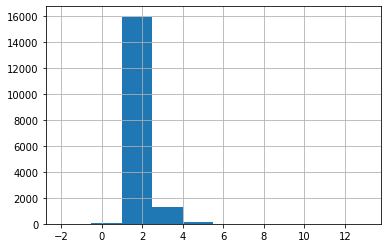

In [ ]:
datoshab['bedrooms'].hist()

Como tiene una distribución bastante simétrica procedemos a ajustar nuestro modelo.

In [ ]:
modelohab=sm.OLS(logY,X)
resultadoshab=modelohab.fit()
print(resultadoshab.summary())

                            OLS Regression Results                            
Dep. Variable:                   logY   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     2258.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:00:19   Log-Likelihood:                -7201.8
No. Observations:               17403   AIC:                         1.441e+04
Df Residuals:                   17399   BIC:                         1.444e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3080      0.007   1316.458      0.0

En este nuevo modelo, β0 es igual a 9,308 y β1 es -0,0000059, valores ligeramente (15%) diferentes a los del modelo anterior. Esto nos dice que la incorporación de la variable dormitorios no tiene un impacto muy importante en la relación entre y con la distancia y el precio. 

Por otro lado, el p-valor de β3 es 0, por lo tanto, rechazamos la hipotesis nula y podemos decir que hay una relación estadísticamente significativa entre las habitaciones y los precios de alquiler. Los p-valores de los β0 y β1 se mantienen en 0, lo que implica que siguen siendo variables estadísticamente significativas.

Para finalizar, vemos que, como es esperable a la hora de agregar variables, el R² aumentó a 0,28 (28%), lo que significa que el modelo explica una mayor cantidad de variabilidad de los datos, es decir tiene una mayor bondad de ajuste.

**c.** En el caso del coeficiente que acompaña la superficie: β2 su valor cambió a 0,000009, una diferencia (desde 3,342e-05 a 9,348e-06) más relevante con respecto al coeficiente anterior. Esta disminución se explica ya que al tener ambas una relación positiva con respecto al valor del alquiler (en ambos casos si aumenta cantidad de habitaciones o superficie aumenta el precio) al incorporarlas a ambas es necesario que baje el coeficiente de superficie para dar lugar al coeficiente de habitaciones. 
Con respecto al p-valor, vemos que la relación de la superficie con el precio sigue siendo estadísticamente significativa pero, está ahora mucho más cerca del área de no rechazo. Esto se ve con claridad en el valor de t que está muy cercano a 2 (2,31).

# Pregunta 7
Las variables **start_year** y **start_mont** presentan la informacion del año y mes en el que el anuncio se publico respectivamente. \\
a. Genere una variable dummy para identificar las observaciones posteriores al advenimiento del covid en marzo 2020 (i.e., 1 si es posterior a marzo 2020 y 0 de otro modo) \\
b. Ingrese la variable dummy al modelo con el que viene trabajando. Interprete el coeficiente.

##**Respuestas** a la Pregunta 7

**a.** Para poder generar la variable dummy que identifique las observaciones posteriores al advenimiento del covid, vamos a tener que realizar algunas operaciones sobre nuestra base de datos. Vamos, primero, a revisar cómo aparecen las fechas de las publicaciones usando la función head().

In [ ]:
gdf.head(10)

,type,type_i18n,country,developmen,operation,operation_,rooms,bedrooms,bathrooms,surface_to,surface_co,price,currency,price_peri,title,lat,lon,l1,l2,l3,l4,l5,l6,distanciaC,start_mont,start_year,infla,adjprice,geometry
0,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,1.0,NaN,1.0,36,30,21000,ARS,Mensual,Departamento - Parque Patricios,-34.630611,-58.406403,Argentina,Capital Federal,Parque Patricios,None,None,None,3782.819022,7,2020,1.566667,13404.255319,POINT (97726.711 96976.446)
1,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,1.0,39,39,17000,ARS,Mensual,Departamento - Recoleta,-34.594606,-58.395260,Argentina,Capital Federal,Recoleta,None,None,None,1584.291795,11,2019,1.133333,15000.000000,POINT (98748.062 100970.892)
3,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,3.0,2.0,1.0,52,52,17000,ARS,None,ALQUILER 3 Amb. Tribunales,-34.601268,-58.389598,Argentina,Capital Federal,b'San Nicol\xe1s',None,None,None,768.329029,11,2019,1.133333,15000.000000,POINT (99267.515 100231.938)
4,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,51,48,24000,ARS,None,EN ALQUILER! Dpto 2 amb luminoso - Recoleta,-34.598618,-58.403637,Argentina,Capital Federal,Recoleta,None,None,None,2087.630655,5,2020,1.400000,17142.857143,POINT (97979.662 100525.772)
5,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,40,40,11000,ARS,Mensual,SIN EXPENSAS - ENTRADA INDEPENDIENTE,-34.676155,-58.515760,Argentina,Bs.As. G.B.A. Zona Oeste,La Matanza,Lomas del Mirador,None,None,14714.206673,10,2020,1.666667,6600.000000,POINT (87705.386 91916.045)
6,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,35,35,20000,ARS,Mensual,Departamento - Lomas de Zamora Oeste,-34.765140,-58.401901,Argentina,Bs.As. G.B.A. Zona Sur,Lomas de Zamora,Lomas de Zamora,None,None,18043.601271,2,2021,1.933333,10344.827586,POINT (98142.619 82052.251)
7,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,NaN,NaN,1.0,46,40,28000,ARS,Mensual,Departamento - Palermo,-34.578066,-58.426532,Argentina,Capital Federal,Palermo,None,None,None,4985.605172,4,2021,2.200000,12727.272727,POINT (95878.344 102805.033)
8,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,1.0,NaN,1.0,32,29,21500,ARS,Mensual,Departamento - B.Santa Rita,-34.612124,-58.484210,Argentina,Capital Federal,Villa Santa Rita,None,None,None,9460.878055,3,2021,2.066667,10403.225806,POINT (90589.712 99022.916)
9,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,3.0,2.0,2.0,62,59,18500,ARS,None,Departamento de 3 ambientes en Alquiler en Alm...,-34.602813,-58.422368,Argentina,Capital Federal,Almagro,None,None,None,3739.003647,6,2019,1.000000,18500.000000,POINT (96261.475 100059.844)
10,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,39,37,14000,ARS,None,"ALQUILER-2 ambientes, zona FACULTADES-Balvanera",-34.606698,-58.396460,Argentina,Capital Federal,Balvanera,None,None,None,1411.368005,1,2020,1.200000,11666.666667,POINT (98638.134 99629.485)


Luego, vamos a generar una columna nueva en nuestra base de datos gdf en la que categoricemos las observaciones que son previas a abril de 2020 y las que son posteriores, colocándole "prepandemia" a las primeras y "pandemia" a las segundas. Para poder realizar esto vamos a utilizar el método loc().

In [ ]:
gdf.loc[(gdf['start_year'] == 2020) & (gdf['start_mont']>=4), 'pandemia'] = 'pandemia'
gdf.loc[(gdf['start_year'] == 2020) & (gdf['start_mont']<4), 'pandemia'] = 'prepandemia'
gdf.loc[(gdf['start_year'] == 2021), 'pandemia'] = 'pandemia'
gdf.loc[(gdf['start_year'] < 2020), 'pandemia'] = 'prepandemia'


Para estar seguros de que realizamos bien el paso anterior vamos a realizar un agrupamiento de las observaciones por año, mes y la nueva variable "pandemia". Aprovechamos el agrupamiento para ver la cantidad de observaciones por cada grupo, de manera de estar seguros de que tenemos una cantidad considerable de datos en ambos.

In [ ]:
gdf.groupby(by=['start_year','start_mont','pandemia']).agg(['count'])['title']

count
start_year start_mont pandemia          
2019       5          prepandemia   1758
           6          prepandemia   1556
           7          prepandemia   1717
           8          prepandemia   1682
           9          prepandemia   1278
           10         prepandemia   1601
           11         prepandemia   1392
           12         prepandemia   1232
2020       1          prepandemia   1364
           2          prepandemia   1295
           3          prepandemia   1071
           4          pandemia       329
           5          pandemia       824
           6          pandemia      1310
           7          pandemia      1068
           8          pandemia      1118
           9          pandemia      1163
           10         pandemia      1299
           11         pandemia      1094
           12         pandemia       916
2021       1          pandemia       662
           2          pandemia       704
           3          pandemia       755
           4          pandemia       747
           5          pandemia       410

Ahora que tenemos categorizados nuestros anuncios podemos generar las variable dummy utilizando la función get_dummies de pandas. La variable dum_pandemia tomará el valor 1 cuando la observación sea en período de pandemia y 0 en prepandemia, la variable dum_prepandemia será a la inversa. 

In [ ]:
dummiespandemia=pd.get_dummies(gdf.pandemia, prefix='dum')
dummiespandemia

,dum_pandemia,dum_prepandemia
0,1,0
1,0,1
3,0,1
4,1,0
5,1,0
...,...,...
29905,0,1
29906,0,1
29907,0,1
29908,0,1


Generada las variables dummy, las unificamos con la base gdf para que cada observación tenga el valor que le corresponda de 1 o 0.

In [ ]:
gdfcovid=pd.concat([gdf, dummiespandemia],axis=1)
gdfcovid

,type,type_i18n,country,developmen,operation,operation_,rooms,bedrooms,bathrooms,surface_to,surface_co,price,currency,price_peri,title,lat,lon,l1,l2,l3,l4,l5,l6,distanciaC,start_mont,start_year,infla,adjprice,geometry,pandemia,dum_pandemia,dum_prepandemia
0,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,1.0,NaN,1.0,36,30,21000,ARS,Mensual,Departamento - Parque Patricios,-34.630611,-58.406403,Argentina,Capital Federal,Parque Patricios,None,None,None,3782.819022,7,2020,1.566667,13404.255319,POINT (97726.711 96976.446),pandemia,1,0
1,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,1.0,39,39,17000,ARS,Mensual,Departamento - Recoleta,-34.594606,-58.395260,Argentina,Capital Federal,Recoleta,None,None,None,1584.291795,11,2019,1.133333,15000.000000,POINT (98748.062 100970.892),prepandemia,0,1
3,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,3.0,2.0,1.0,52,52,17000,ARS,None,ALQUILER 3 Amb. Tribunales,-34.601268,-58.389598,Argentina,Capital Federal,b'San Nicol\xe1s',None,None,None,768.329029,11,2019,1.133333,15000.000000,POINT (99267.515 100231.938),prepandemia,0,1
4,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,51,48,24000,ARS,None,EN ALQUILER! Dpto 2 amb luminoso - Recoleta,-34.598618,-58.403637,Argentina,Capital Federal,Recoleta,None,None,None,2087.630655,5,2020,1.400000,17142.857143,POINT (97979.662 100525.772),pandemia,1,0
5,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,40,40,11000,ARS,Mensual,SIN EXPENSAS - ENTRADA INDEPENDIENTE,-34.676155,-58.515760,Argentina,Bs.As. G.B.A. Zona Oeste,La Matanza,Lomas del Mirador,None,None,14714.206673,10,2020,1.666667,6600.000000,POINT (87705.386 91916.045),pandemia,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29905,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,1.0,NaN,1.0,31,28,14000,ARS,None,Departamento de 1 ambiente en Alquiler en Palermo,-34.590654,-58.424030,Argentina,Capital Federal,Palermo,None,None,None,4138.611068,6,2019,1.000000,14000.000000,POINT (96108.472 101408.584),prepandemia,0,1
29906,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,55,52,21500,ARS,None,ALQUILER DEPARTAMENTO 2 AMBIENTES CON COCHERA,-34.617710,-58.439745,Argentina,Capital Federal,Caballito,None,None,None,5564.613456,2,2020,1.233333,17432.432432,POINT (94668.450 98406.421),prepandemia,0,1
29907,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,1.0,35,35,10800,ARS,Mensual,DEPTO 2 AMBIENTES EN ALQUILER EN GENERAL PACH...,-34.457697,-58.637984,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,General Pacheco,None,None,28550.497724,7,2019,1.066667,10125.000000,POINT (76441.965 116129.163),prepandemia,0,1
29908,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,2.0,80,80,22000,ARS,None,b'Senador Mor\xf3n 100 - $ 22.000 - Departam...,-34.563705,-58.690399,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,Bella Vista,None,None,28671.344310,11,2019,1.133333,19411.764706,POINT (71661.437 104355.664),prepandemia,0,1


**b.** Ingresamos la variable dummy al modelo

Modelo incorporando la variable dummy dum_pandemia:

$log(adjprice_i)=\beta_0+\beta_1*distanciaC_i+ \beta_2*surface_i + \beta_3*bedrooms_i + \beta_4*Dpandemia + \epsilon_i$

In [ ]:
datoscovid=gdfcovid[['adjprice', 'distanciaC', 'surface_to','bedrooms','dum_pandemia']]
datoscovid=datoscovid.dropna()
datoscovid['logY']=np.log(datoscovid.adjprice)

datoscovid

,adjprice,distanciaC,surface_to,bedrooms,dum_pandemia,logY
3,15000.000000,768.329029,52,2.0,0,9.615805
4,17142.857143,2087.630655,51,1.0,1,9.749337
5,6600.000000,14714.206673,40,1.0,1,8.794825
6,10344.827586,18043.601271,35,1.0,1,9.244242
9,18500.000000,3739.003647,62,2.0,0,9.825526
...,...,...,...,...,...,...
29901,17000.000000,2413.261258,45,1.0,0,9.740969
29902,15937.500000,4897.574765,50,1.0,1,9.676430
29904,15000.000000,10716.392315,57,1.0,0,9.615805
29906,17432.432432,5564.613456,55,1.0,0,9.766088


In [ ]:
logY=datoscovid.logY
X=datoscovid[['distanciaC','surface_to','bedrooms','dum_pandemia']]
X=sm.add_constant(X)
X

,const,distanciaC,surface_to,bedrooms,dum_pandemia
3,1.0,768.329029,52,2.0,0
4,1.0,2087.630655,51,1.0,1
5,1.0,14714.206673,40,1.0,1
6,1.0,18043.601271,35,1.0,1
9,1.0,3739.003647,62,2.0,0
...,...,...,...,...,...
29901,1.0,2413.261258,45,1.0,0
29902,1.0,4897.574765,50,1.0,1
29904,1.0,10716.392315,57,1.0,0
29906,1.0,5564.613456,55,1.0,0


In [ ]:
modelocovid=sm.OLS(logY,X)
resultadoscovid=modelocovid.fit()
print(resultadoscovid.summary())

                            OLS Regression Results                            
Dep. Variable:                   logY   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1721.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:00:20   Log-Likelihood:                -7162.4
No. Observations:               17403   AIC:                         1.433e+04
Df Residuals:                   17398   BIC:                         1.437e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.3385      0.008   1190.556   

Como podemos observar, la variable pandemia es estadísticamente significativa ya que el p-valor da 0. El valor que toma es -0,0495 lo que significa que en período de pandemia los valores de alquiler bajaron con respecto a los de prepandemia. El valor representa la variación del valor de la constante de la recta cuando se activa el dummy, es decir, la variación del valor de base (corte con el eje Y) de la recta cuando la fecha de la observación es mayor a marzo del 2020. Esto se puede observar bien en la ecuación:

$log(adjprice_i)=\beta_0+\beta_1*distanciaC_i+ \beta_2*surface_i + \beta_3*bedrooms_i + \beta_4*Dpandemia + \epsilon_i$

Cuando Dpandemia es 1, entonces:

$log(adjprice_i)=\beta_0+\beta_1*distanciaC_i+ \beta_2*surface_i + \beta_3*bedrooms_i + \beta_4*1 + \epsilon_i$

$log(adjprice_i)=(\beta_0+ \beta_4)+\beta_1*distanciaC_i+ \beta_2*surface_i + \beta_3*bedrooms_i + \epsilon_i$

En este caso $\beta_0+\beta_4$ es (9,3385-0,0495), por lo tanto, desde el arranque de la recta los valores de los alquileres en pandemia son menores.


 R² no tuvo una gran variación con respecto al modelo anterior. 

Como nos resulta poco intuitivo el resultado de la regresión lineal, decidimos realizar un gráfico de dispersión con las fechas en el eje x y los precios en el eje y, de manera de poder identificar rápidamente si los datos en la base tienen valores más bajos en las fechas posteriores a marzo de 2020. Agregamos para poder hacerlo, una columna nueva con un concatenado de año y mes.

In [ ]:
gdf['start_year'] = gdf['start_year'].astype(str)
gdf['start_mont'] = gdf['start_mont'].astype(str)
gdf['fecha']= gdf[['start_year', 'start_mont']].agg('-'.join, axis=1)
gdf

,type,type_i18n,country,developmen,operation,operation_,rooms,bedrooms,bathrooms,surface_to,surface_co,price,currency,price_peri,title,lat,lon,l1,l2,l3,l4,l5,l6,distanciaC,start_mont,start_year,infla,adjprice,geometry,pandemia,fecha
0,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,1.0,NaN,1.0,36,30,21000,ARS,Mensual,Departamento - Parque Patricios,-34.630611,-58.406403,Argentina,Capital Federal,Parque Patricios,None,None,None,3782.819022,7,2020,1.566667,13404.255319,POINT (97726.711 96976.446),pandemia,2020-7
1,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,1.0,39,39,17000,ARS,Mensual,Departamento - Recoleta,-34.594606,-58.395260,Argentina,Capital Federal,Recoleta,None,None,None,1584.291795,11,2019,1.133333,15000.000000,POINT (98748.062 100970.892),prepandemia,2019-11
3,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,3.0,2.0,1.0,52,52,17000,ARS,None,ALQUILER 3 Amb. Tribunales,-34.601268,-58.389598,Argentina,Capital Federal,b'San Nicol\xe1s',None,None,None,768.329029,11,2019,1.133333,15000.000000,POINT (99267.515 100231.938),prepandemia,2019-11
4,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,51,48,24000,ARS,None,EN ALQUILER! Dpto 2 amb luminoso - Recoleta,-34.598618,-58.403637,Argentina,Capital Federal,Recoleta,None,None,None,2087.630655,5,2020,1.400000,17142.857143,POINT (97979.662 100525.772),pandemia,2020-5
5,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,40,40,11000,ARS,Mensual,SIN EXPENSAS - ENTRADA INDEPENDIENTE,-34.676155,-58.515760,Argentina,Bs.As. G.B.A. Zona Oeste,La Matanza,Lomas del Mirador,None,None,14714.206673,10,2020,1.666667,6600.000000,POINT (87705.386 91916.045),pandemia,2020-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29905,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,1.0,NaN,1.0,31,28,14000,ARS,None,Departamento de 1 ambiente en Alquiler en Palermo,-34.590654,-58.424030,Argentina,Capital Federal,Palermo,None,None,None,4138.611068,6,2019,1.000000,14000.000000,POINT (96108.472 101408.584),prepandemia,2019-6
29906,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,1.0,1.0,55,52,21500,ARS,None,ALQUILER DEPARTAMENTO 2 AMBIENTES CON COCHERA,-34.617710,-58.439745,Argentina,Capital Federal,Caballito,None,None,None,5564.613456,2,2020,1.233333,17432.432432,POINT (94668.450 98406.421),prepandemia,2020-2
29907,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,1.0,35,35,10800,ARS,Mensual,DEPTO 2 AMBIENTES EN ALQUILER EN GENERAL PACH...,-34.457697,-58.637984,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,General Pacheco,None,None,28550.497724,7,2019,1.066667,10125.000000,POINT (76441.965 116129.163),prepandemia,2019-7
29908,Propiedad,Departamento,Argentina,None,Alquiler,Alquiler,2.0,NaN,2.0,80,80,22000,ARS,None,b'Senador Mor\xf3n 100 - $ 22.000 - Departam...,-34.563705,-58.690399,Argentina,Bs.As. G.B.A. Zona Norte,San Miguel,Bella Vista,None,None,28671.344310,11,2019,1.133333,19411.764706,POINT (71661.437 104355.664),prepandemia,2019-11


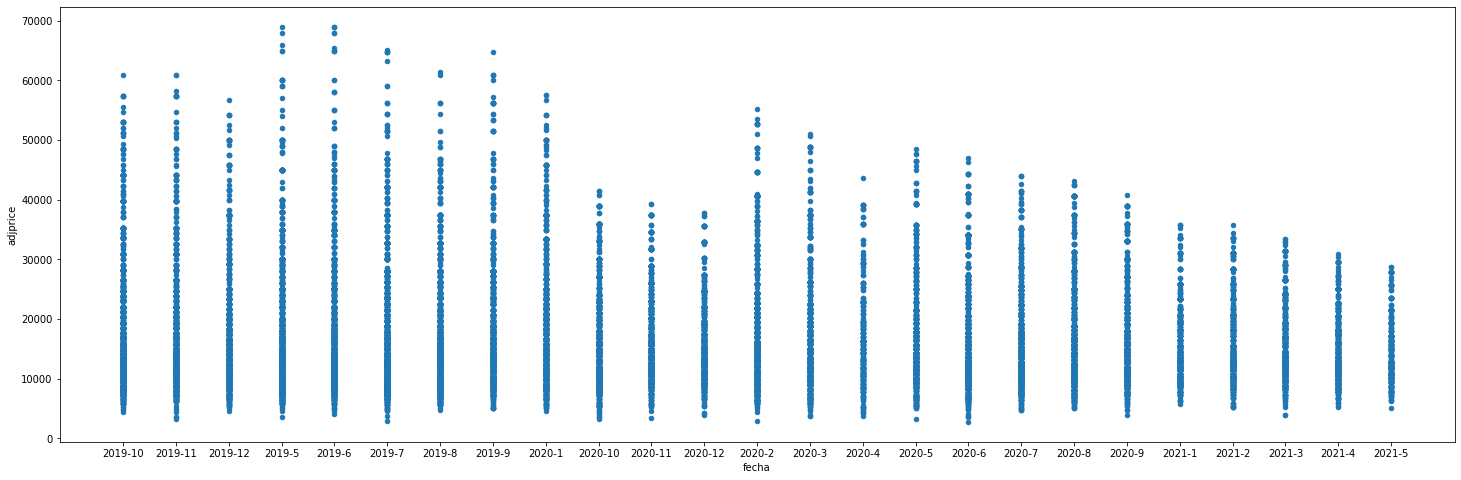

In [ ]:
gdf.sort_values('fecha').plot.scatter(x='fecha',  y='adjprice', figsize=(25, 8))

El gráfico nos da la pauta de que efectivamente los precios de los alquileres tendieron a ser más bajos a partir del advenimiento del Covid-19, según los datos de Properati. Hay que tener en cuenta que la cantidad de observaciones es bastante inferior en el período de pandemia, por lo que podrían no ser igual de representativos que en prepandemia -si bien siguen siendo un número elevado-. Asimismo, podemos suponer que hay anuncios que no están relevados dado que, de haber tenido una restricción de la oferta lo esperable es que haya un aumento de precios y no una disminución. 

Por su parte, un factor que es relevante para considerar nuestra muestra es que estamos observando únicamente departamentos en alquiler y no los precios de todos los inmuebles en alquiler, por lo que es muy probable que haya caído la demanda de departamentos en alquiler a partir de la pandemia, que se ha desplazado hacia viviendas con jardín o parque y casas más espaciosas. Esto es algo que revisaremos más pormenorizadamente en el punto 8.

A todo ello se suma la recesión de la economía, que afecta al mercado de alquileres, y que puede provocar que el valor real de los alquileres baje efectivamente, independientemente de la capacidad de pago de la demanda que está atada a sus ingresos -y que seguramente hayan descendido también-.

# Pregunta 8

En esta punto vamos a indagar la hipótesis de que el COVID afectó el gradiente urbano de alquileres. Vamos a estimar el siguiente modelo:

$$
alquiler_i=\beta_0+\beta_1distanciaC_i+\beta_2(distanciaC_i * Post_t)+\epsilon_i
$$

donde $Post_t$ es una variable dummy que identifica si la oferta fue realizada posterior a marzo 2020 y 0 de otro modo (calculada en el punto anterior).
Note que la variable que acompaña a $\beta_2$ en la ecuacion ($distanciaC_i * Post_t$)  es la multiplicación entre la distancia al CBD y la variable dummy $Post_t$. **Esta es una variable que usted debera generar por separado.** \\
a. Estime el modelo. Interprete los coeficientes obtenidos. \\
b. Es $\beta_2$ estadisticamente significativo? Como se interpreta este resultado? \\
c. (Opcional) Realice un grafico de las predicciones del modelo contra la variable distancia, de manera similar al punto 2.c
d. ¿Cuáles son sus conclusiones en relacion al efecto del Covid sobre el gradiente de alquileres?


##**Respuestas** a la Pregunta 8

**a.** Para poder estimar el modelo, primero, debemos generar la variable: $$ distanciaC_i * Post_t $$ (Postt es aquella variable que nosotros llamamos dum_pandemia) 

In [ ]:
datoscovid['dist_dumpan']=datoscovid.distanciaC*datoscovid.dum_pandemia
datoscovid

,adjprice,distanciaC,surface_to,bedrooms,dum_pandemia,logY,dist_dumpan
3,15000.000000,768.329029,52,2.0,0,9.615805,0.000000
4,17142.857143,2087.630655,51,1.0,1,9.749337,2087.630655
5,6600.000000,14714.206673,40,1.0,1,8.794825,14714.206673
6,10344.827586,18043.601271,35,1.0,1,9.244242,18043.601271
9,18500.000000,3739.003647,62,2.0,0,9.825526,0.000000
...,...,...,...,...,...,...,...
29901,17000.000000,2413.261258,45,1.0,0,9.740969,0.000000
29902,15937.500000,4897.574765,50,1.0,1,9.676430,4897.574765
29904,15000.000000,10716.392315,57,1.0,0,9.615805,0.000000
29906,17432.432432,5564.613456,55,1.0,0,9.766088,0.000000


Separamos las variables que vamos a necesitar para nuestro modelo y lo estimamos.

In [ ]:
logY=datoscovid.logY
X=datoscovid[['distanciaC','dist_dumpan']]
X=sm.add_constant(X)
X

,const,distanciaC,dist_dumpan
3,1.0,768.329029,0.000000
4,1.0,2087.630655,2087.630655
5,1.0,14714.206673,14714.206673
6,1.0,18043.601271,18043.601271
9,1.0,3739.003647,0.000000
...,...,...,...
29901,1.0,2413.261258,0.000000
29902,1.0,4897.574765,4897.574765
29904,1.0,10716.392315,0.000000
29906,1.0,5564.613456,0.000000


In [ ]:
modelo=sm.OLS(logY,X)
resultadoscovid2=modelo.fit()
print(resultadoscovid2.summary())

                            OLS Regression Results                            
Dep. Variable:                   logY   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     259.4
Date:                Sun, 05 Sep 2021   Prob (F-statistic):          9.34e-112
Time:                        21:00:23   Log-Likelihood:                -9806.9
No. Observations:               17403   AIC:                         1.962e+04
Df Residuals:                   17400   BIC:                         1.964e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.7743      0.005   2111.868      

Como podemos observar, β1 -como habíamos visto en modelos anteriores- y β2, en este caso, son negativas, lo que implica que no sólo el valor de los alquileres disminuye con la distancia en general, sino que lo hace más pronunciadamente si esos alquileres fueron durante la pandemia. Nuestra nueva variable lo que hace es aumentar la pendiente (negativa) de la recta. Esto lo podemos ver con mayor claridad en la ecuación: 
$$
log(alquiler_i)=\beta_0+\beta_1distanciaC_i+\beta_2(distanciaC_i * Post_t)+\epsilon_i
$$
Cuando la observación es en el período de pandemia, entonces Postt = 1
$$
log(alquiler_i)=\beta_0+\beta_1distanciaC_i+\beta_2(distanciaC_i * 1)+\epsilon_i
$$
Por lo tanto: 
$$
log(alquiler_i)=\beta_0+(\beta_1 +\beta_2) distanciaC_i+\epsilon_i
$$
Con los coeficientes estimados:
$$
log(alquiler_i)=9,77+(-0,0000036 - 0,0000047)*distanciaC_i+\epsilon_i
$$

$$
log(alquiler_i)=9,77-0,0000083 * distanciaC_i+\epsilon_i
$$

Esto lo que quiere decir es que en período de pandemia, el porcentaje que cambió Y cuando cambió una unidad de X es -0,00083%, mientras que en prepandemia ese porcentaje era -0,00036%.


**b.** β2  es estadísticamente significativo ya que el p-valor da 0,00. Esto significa que se rechaza la hipótesis nula que estipula que no hay una modificación en el gradiente de precios de alquileres según la distancia previo y antes de la pandemia (β2 = 0). Al rechazarse la hipótesis nula, entonces, podemos estar seguros de que β2 es distinto de 0 y que por lo tanto hay una diferencia en el gradiente previo y posterior al advenimiento del covid-19.

**c.** Para poder mostrar de una manera más intuitiva lo que mencionamos en el punto anterior, podemos graficar un scatterplot que nos muestre los valores $\hat{Y}$ para todas las X de nuestros datos de manera de poder visualizar las rectas de predicción de nuestro modelo. Para esto tenemos que calcular los valores que toma $\hat{Y}$ para cada valor de X en nuestra base de datos. Luego, realizamos el gráfico.

In [ ]:
ypred = resultadoscovid2.predict(X)

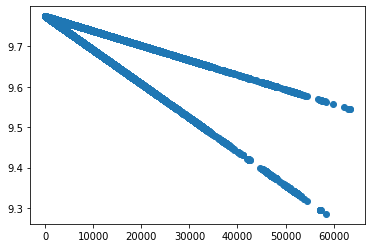

In [ ]:
plt.scatter(datoscovid.distanciaC, ypred)

Las conclusiones que podemos mencionar con respecto a los efectos del Covid-19 sobre el gradiente de los precios de alquiler de departamentos, es que la afectó en gran medida. Como mencionamos en el punto 7, es relevante considerar que en nuestra muestra estamos observando únicamente departamentos en alquiler y no los precios de todos los inmuebles en alquiler, por lo que es muy probable que, fundamentalmente en el Conurbano Bonaerense, haya caído la demanda de departamentos en alquiler a partir de la pandemia, que se ha desplazado hacia viviendas con jardín o parque y casas más espaciosas. Esto explica por qué el precio baja más en la conurbación. Presumiblemente, quien se desplaza de la Ciudad de Buenos Aires durante la pandemia en busca de inmuebles con más metros cuadrados no se mueva a un departamento en el Conurbano sino que demande una casa. 
De este modo, si estuviéramos incluyendo en nuestro análisis casas en alquiler, es posible que pueda verse que la distancia al CBD encarece el precio del alquiler de las propiedades; es decir, una relación positiva entre distancia y precio. Sería interesante poder realizar un test de hipótesis en este sentido.

#Pregunta 9 (opcional)
Realice una hipótesis adicional relacionada al efecto de la pandemia que pueda testear en base a los datos provistos. Especifique el modelo y testee su hipótesis.

#**Respuesta** a la Pregunta 9

Una hipótesis que nos parecía interesante testear con los datos provistos, es si la pandemia tuvo un efecto sobre los valores de los alquileres teniendo en consideración su superficie, es decir, si se valorizaron o desvalorizaron los departamentos de mayor superficie por sobre los de menor superficie en un período respecto del otro. Para esto, armamos un modelo similar al del punto anterior pero con la variable superficie. Incorporamos una nueva variable (superficie_to * dum_pandemia) que se activará en los casos que la observación sea del período de la pandemia y nos permitirá ver si hay un efecto.   

$$
log(alquiler_i)=\beta_0+\beta_2superficietotal_i+\beta_3(superficietotal_i * Post_t)+\epsilon_i
$$

In [ ]:
datoscovid2=gdfcovid[['adjprice', 'surface_to','dum_pandemia']]
datoscovid2=datoscovid2.dropna()
datoscovid2['logY']=np.log(datoscovid2.adjprice)
datoscovid2['sup_dumpan']=datoscovid2['surface_to']*datoscovid2['dum_pandemia']

datoscovid2

,adjprice,surface_to,dum_pandemia,logY,sup_dumpan
0,13404.255319,36,1,9.503327,36
1,15000.000000,39,0,9.615805,0
3,15000.000000,52,0,9.615805,0
4,17142.857143,51,1,9.749337,51
5,6600.000000,40,1,8.794825,40
...,...,...,...,...,...
29905,14000.000000,31,0,9.546813,0
29906,17432.432432,55,0,9.766088,0
29907,10125.000000,35,0,9.222763,0
29908,19411.764706,80,0,9.873635,0


Realizamos un histograma de los valores de las superficies totales de los alquileres, para ver su distribución:

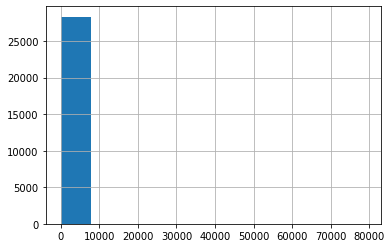

In [ ]:
datoscovid2['surface_to'].hist()

No podemos ver claramente la distribución porque parecieran haber muy pocos datos con superficies muy elevadas (hasta 80000 metros). Al ser una base de datos de departamentos estimamos que son datos erroneos.

In [ ]:
datoscovid2.groupby('surface_to').agg(['count'])['adjprice']

,count
surface_to,
10,8
11,3
12,1
14,4
15,10
...,...
9053,1
9482,1
9525,1


Nos quedamos con el 95% de datos como para evitar el 5% de datos extremos (outliers). Volvemos a realizar el histograma.

In [ ]:
datoscovid3=datoscovid2.loc[datoscovid2.surface_to<datoscovid2.surface_to.quantile(.95)]

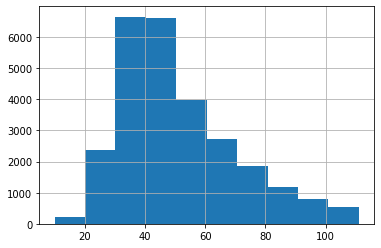

In [ ]:
datoscovid3['surface_to'].hist()

Como podemos ver los datos son de departamentos entre 10 y 110 metros cuadrados (lo esperable para la variables departamentos). Ahora si estimamos nuestro modelo.

In [ ]:
logY=datoscovid3.logY
X=datoscovid3[['surface_to','sup_dumpan']]
X=sm.add_constant(X)
X

,const,surface_to,sup_dumpan
0,1.0,36,36
1,1.0,39,0
3,1.0,52,0
4,1.0,51,51
5,1.0,40,40
...,...,...,...
29905,1.0,31,0
29906,1.0,55,0
29907,1.0,35,0
29908,1.0,80,0


In [ ]:
modelo=sm.OLS(logY,X)
resultadoscovid3=modelo.fit()
print(resultadoscovid3.summary())

                            OLS Regression Results                            
Dep. Variable:                   logY   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     9820.
Date:                Sun, 05 Sep 2021   Prob (F-statistic):               0.00
Time:                        21:00:24   Log-Likelihood:                -7017.8
No. Observations:               26923   AIC:                         1.404e+04
Df Residuals:                   26920   BIC:                         1.407e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8725      0.006   1607.636      0.0

Como podemos observar, β1 y β2, en este caso, son positivas, lo que implica que no sólo el valor de los alquileres aumenta con el aumento de la superficie del departamento, sino que lo hace más pronunciadamente (aunque levemente) si esos alquileres fueron durante la pandemia. Nuestra nueva variable lo que hace es aumentar la pendiente (positiva) de la recta. Esto lo podemos ver con mayor claridad en la ecuación: 

$$
log(alquiler_i)=\beta_0+\beta_1superficietotal_i+\beta_2(superficietotal_i * Post_t)+\epsilon_i
$$

Cuando es una observación en período de pandemia Postt = 1 

$$
log(alquiler_i)=\beta_0+\beta_1superficietotal_i+\beta_2(superficietotal_i * 1)+\epsilon_i
$$

$$
log(alquiler_i)=\beta_0+(\beta_2+\beta_3)*superficietotal_i+\epsilon_i
$$

$$
log(alquiler_i)=\beta_0+(0,0139+0,0003)*superficietotal_i+\epsilon_i
$$

$$
log(alquiler_i)=\beta_0+(0,0142)*superficietotal_i+\epsilon_i
$$

Esto lo que quiere decir es que en período de pandemia, el porcentaje que cambió la variable Y cuando cambió una unidad de X (superficie) es +1,42%, mientras que en prepandemia ese porcentaje era +1,39%. Aunque el valor es pequeño, es estadísticamente significativo.

β2  es estadísticamente significativo ya que el p-valor da 0,00. Esto significa que se rechaza la hipótesis nula que estipula que no hay una modificación en el gradiente de precios de alquileres según la superficie previo y luego de la pandemia (β2 = 0). Al rechazarse la hipótesis nula, entonces, podemos estar seguros de que β2 es distinto de 0 y que por lo tanto hay una diferencia (positiva) en el gradiente de precios debido a la superficie en período de covid-19. 

Además, podemos observar que R² es 0,422, lo que significa que el modelo logra captar un 42,2% de la variabilidad de los datos, un número bastante mayor que lo que habíamos logrado en los modelos anteriores incluso utilizando mayor cantidad de variables. 

Graficamos un scatterplot con los puntos que toma $\hat{Y}$ para los diversos valores de X de nuestros datos y de esta manera visualizamos las dos rectas con su leve diferencia en la pendiente que mencionamos en los párrafos anteriores.

In [ ]:
ypred = resultadoscovid3.predict(X)

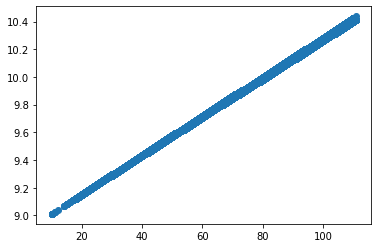

In [ ]:
plt.scatter(datoscovid4.surface_to, ypred)

Para finalizar, revisamos la distribución de los errores para estar seguros de que están dados los supuestos como para dar por válido nuestra test de hipótesis.

In [ ]:
residuoscovid=logY-ypred

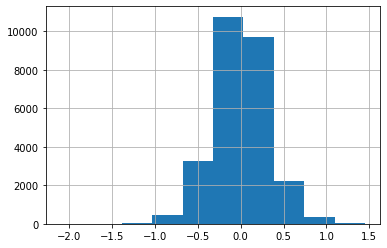

In [ ]:
residuoscovid.hist()

Efectivamente el error tiene una distribución normal, podemos estar seguros de que nuestro test de hipótesis es válido. 

Lo que nos resulta significativo de los resultados del modelo es que a pesar de que vimos que hay una desvalorización de los alquileres en período de pandemia, que se acentúa en la distancia al Centro de Negocios, en el caso de la superficie encontramos un valorización -aunque leve-. Esto nos da la pauta de que hay mucho más por indagar, por ejemplo, incorporando superficies descubiertas y alquileres de casas (incluso en barrios privados y countries) para entender de manera más completa los efectos de la pandemia en el mercado de alquileres.